# Desarrollo

A continuación, se presenta el avance que se tiene en la creación del prototipo para la aplicación de análisis de sentimiento a las conferencias de prensa, esta sección ha sido desarrollada por medio de la tecnología “Jupyter Notebook” que permite integrar texto y código en un mismo documento. El código está identificado con un tipo diferente de letra y se han mantenido los comentarios, identificados en color azul y por iniciar con el signo “#”. 

Se hace uso de una librería llamada Dynaconf para guardar los datos de configuración en un archivo “.env” separado. Esto facilita que, si alguien más desea ejecutar el código en una computadora diferente, únicamente sea necesario modificar el contenido de ese archivo y no todo el código.

Iniciamos por abrir el archivo para leer su contenido.


In [1]:
import pandas as pd
from dynaconf import Dynaconf

# Obtener archivo de texto a utilizar como fuente
settings = Dynaconf(load_dotenv=True, envvar_prefix="PFM")

abrir_archivo = settings.FILE

with open(abrir_archivo, 'r', encoding="UTF-8") as file:
    text = file.read()

Una vez que tenemos el archivo disponible se realizan otras tareas de limpieza, las cuales están indicadas en los comentarios del código.

In [2]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords

# Separar palabras
tokens = word_tokenize(text)

# Transformar a minúsculas
tokens = [w.lower() for w in tokens]

# Quitar puntuación
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]

# Quitar otros caracteres no alfanuméricos
words = [word for word in stripped if word.isalpha()]

# Quitar palabras comunes (stop words)
stop_words = stopwords.words('spanish')

# Agregar palabras que se pueden considerar superfluas y que no están en el paquete de stopwords
personal_words = ['si','mas', 'buenos', 'buenas', 'días', 'gracias', 'señor', 'presidente', 'así']

stop_words = stop_words + personal_words

words = [w for w in words if not w in stop_words]


Al finalizar las operaciones de limpieza, una de las cosas que podemos hacer es determinar la distribución de frecuencia de las palabras en el texto y graficar las palabras más comunes.

In [3]:
from nltk.probability import FreqDist

# Obtener la frecuencia de las palabras
freq_dist = FreqDist(words)

df = pd.DataFrame(list(freq_dist.items()), columns = ["Word","Frequency"])

Antes de realizar la gráfica, se procede a mostrar la lista de palabras junto con el número de veces que aparece.

In [4]:
# Mostrar las 30 más usadas con su número de apariciones
df.sort_values('Frequency', ascending=False).head(30)

,Word,Frequency
958,entonces,14798
11,vamos,14227
139,va,14191
78,méxico,12792
194,mil,12488
425,gobierno,9380
748,aquí,9213
131,ahora,7475
67,caso,7434
68,ver,7383


Y después se realiza la gráfica.

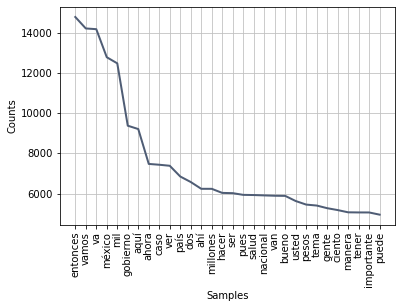

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [20]:
# Graficar las 30 más utilizadas
freq_dist.plot(30, cumulative=False, color="#4f5d75")

Otra actividad que podemos hacer es localizar los “ngrams” más comunes. Un “ngram” es un grupo de 2 o más palabras y nltk ofrece funciones para localizar los grupos de 2, 3 y 4 palabras.

Grupos de 2 palabras o “bigrams”:

In [21]:
import nltk.collocations as nc

bigram_finder = nc.BigramCollocationFinder.from_words(words)
bigram_finder.ngram_fd.most_common(5)
bigram_finder.ngram_fd.tabulate(5)

    ('mil', 'millones')   ('millones', 'pesos')    ('ciudad', 'méxico') ('guardia', 'nacional')   ('pesos', 'centavos') 
                   2594                    2278                    1801                    1657                    1574 


Grupos de 3 palabras o “trigrams”

In [22]:
trigram_finder = nc.TrigramCollocationFinder.from_words(words)
trigram_finder.ngram_fd.most_common(5)
trigram_finder.ngram_fd.tabulate(5)

           ('mil', 'millones', 'pesos') ('comisión', 'federal', 'electricidad')          ('pesos', 'centavos', 'litro')    ('fiscalía', 'general', 'república')          ('mil', 'millones', 'dólares') 
                                   1481                                     665                                     518                                     500                                     342 


Grupos de 4 palabras o “quadgrams”

In [23]:
quadgram_finder = nc.QuadgramCollocationFinder.from_words(words)
quadgram_finder.ngram_fd.most_common(5)
quadgram_finder.ngram_fd.tabulate(5)

     ('andrés', 'manuel', 'lópez', 'obrador')      ('pesos', 'centavos', 'litro', 'margen') ('instituto', 'mexicano', 'seguro', 'social')           ('dos', 'mil', 'millones', 'pesos')    ('precio', 'público', 'pesos', 'centavos') 
                                          242                                           236                                           145                                           127                                           116 


Lo anterior, aunque nos da información sobre el texto, no es precisamente análisis de sentimiento, que es el objetivo planteado. Para comenzar con ello se utilizará una librería de Python con un modelo de análisis de sentimiento previamente entrenado.

In [24]:
from sentiment_analysis_spanish import sentiment_analysis
from nltk import sent_tokenize

# Generamos una variable para el modelo de análisis de sentimiento
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

# Separamos el texto en frases
sentencias = sent_tokenize(text)

# Variable para almacenar el análisis de sentimiento por frase
prob_sentimiento = []

for s in sentencias:
    prob_sentimiento.append([sentiment.sentiment(s), s])

# Convertir a dataframe y ordenar análisis de sentimiento de positivo a negativo
df = pd.DataFrame(prob_sentimiento, columns=['sentimiento', 'frase']).sort_values(by='sentimiento', ascending=False)

Como último paso durante la aplicación del modelo se han cargado los resultados en un DataFrame de Pandas, lo cual permite realizar otras actividades de análisis sobre lo obtenido.

Primero podemos describir lo que contiene el DataFrame:

In [25]:
df.describe()

,sentimiento
count,1.934050e+05
mean,1.013001e-01
std,2.038487e-01
min,1.795110e-45
25%,4.534079e-06
50%,1.979741e-03
75%,7.895718e-02
max,1.000000e+00


La función utilizada nos devuelve información sobre la columna "sentimiento" que es la que contiene valores numéricos. Se muestran el total de registros, los valores mínimo y máximo, la media y la desviación estándar y los valores en donde se concentran el 25%, 50% y 75% de los registros.

Posteriormente, la información almacenada en el DataFrame se puede mostrar en formato tabular. En este caso, como ya se ha mencionado, la columna “sentimiento” contiene valores numéricos, estos están distribuidos entre 0 y 1. Los que más se acercan a 1, corresponden con sentimiento positivo y los que se acercan más a 0 con sentimiento negativo.

Primero se muestran los 15 registros con los valores más altos y podemos observar que todos ellos tienen el valor 1, es decir que su sentimiento se analiza como completamente positivo.


In [7]:
print(df.head(n=15).to_string(index=False))

 sentimiento                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     frase
         1.0                                                                     

A continuación, se muestran los últimos 15 registros, que corresponden a los que tienen valores más cercanos a 0 o un sentimiento muy negativo, en este caso el sentimiento incluso esta expresado en notación exponencial debido a que son valores muy pequeños. 

También es importante señalar que, debido a la función utilizada y a diferencia de los 15 primeros registros, el último registro es el que tiene la calificación más baja.


In [8]:
print(df.tail(n=15).to_string(index=False))

 sentimiento                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Enseguida podemos obtener las 15 frases que tienen un sentimiento cercano a 0.5, lo cual les confiere un valor neutro, es decir que no son positivas o negativas.

In [17]:
pd.set_option('display.max_colwidth', 800)
df.loc[(df['sentimiento'] >= 0.500) & (df['sentimiento'] < 0.501)]


,sentimiento,frase
5638,0.500993,En marzo inicia la fase 2 de pruebas allá en Cuba.
180003,0.500965,"Y lo intentaron, porque abajo hay una gran reserva de valores culturales, morales, espirituales."
11369,0.500854,¿Puedes mañana hacerla?
129173,0.500717,Es amplia la información de hoy.
18743,0.500609,"Demian Duarte, del canal Sonora Power, de Lobos FM y Política y RockandRoll Radio, de Sonora."
146421,0.500609,"Presidente del Gobierno de México, Carlos Pozos, reportero de Petróleo y Energía."
172569,0.500490,Estuvo muy bien lo de ayer.
187747,0.500424,"Bueno, espero haberte contestado."
156693,0.500360,"En particular hubo un operativo muy importante en el municipio de Mezcala y el ejido de Carrizalillo, el de Huitzuco, que está en proceso, y el operativo que en estos momentos, también es del dominio público, estamos llevando a cabo en Tepecoacuilco."
79105,0.500323,Y es en este aniversario de la huelga de Cananea.


En lo que se refiere a datos estadísticos, partimos del total de frases que se obtuvieron tras la aplicación del modelo, aunque se mostraron más arriba, podemos volver a realizar el conteo:

In [27]:
df.count()

sentimiento    193405
frase          193405
dtype: int64

Es importante notar que las funciones de los DataFrames habitualmente muestran todas las columnas y sólo consideran los valores que no contengan datos nulos. 

También podemos obtener datos por columna, especificando a cuál se debe de aplicar, así podemos mostrar con más detalle la media de la columna de sentimiento.


In [18]:
df['sentimiento'].mean()

0.10130010517067133

Por lo que podemos apreciar, es un valor que bajo que representa sentimiento negativo. 

Adicionalmente se puede filtrar los registros que tienen valores mayores a 0.5.


In [28]:
df[df['sentimiento'] > 0.5].count()

sentimiento    12221
frase          12221
dtype: int64

Una vez hecha la operación, se aprecia que de las 193,405 frases que nos generó la aplicación del modelo, únicamente 12,221 entran en el rango que tiende al sentimiento positivo.

También podemos contar las frases que tienen valores muy bajos en el nivel de sentimiento.


In [35]:
df[df['sentimiento'] < 0.001].count()

sentimiento    89710
frase          89710
dtype: int64

Con lo que podemos observar que un porcentaje muy alto de frases caen en este supuesto, pues tenemos 89,710 de 193,405.

Para que sea más visible, los DataFrames ofrecen la opción de generar gráficas, por lo que podemos generar un histograma.

<AxesSubplot:ylabel='Frequency'>

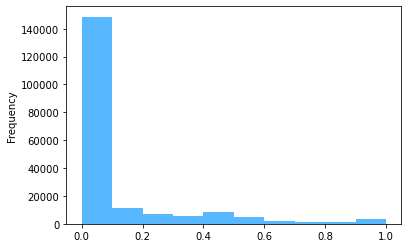

In [31]:
df.sentimiento.plot.hist(color="#57b8ff")

O una gráfica de densidad.

<AxesSubplot:ylabel='Density'>

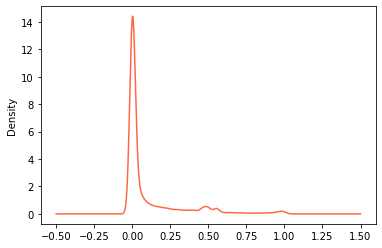

In [32]:
df.sentimiento.plot.density(color="#fe6847")

Ambas gráficas nos muestran que la mayor parte de las frases se concentran en el espectro negativo.

Como se había mencionado anteriormente, existen diferentes modelos pre entrenados para realizar el análisis de sentimientos; a continuación, se muestran los resultados de aplicar una segunda opción. Este paquete se llama “pysentimiento” y está basado en la tecnología de “transformer” desarrollada por HuggingFace. Debido al tiempo que tarda en procesarse se muestra el código utilizado y se ha guardado la información en un archivo “pickle” para poder facilitar su posterior tratamiento. Para la ejecución con este modelo, en lugar de utilizar el archivo de texto se decidió conectar directamente con una base de datos MySQL.

In [ ]:
import pandas as pd
import mysql.connector as msql
import regex
from dynaconf import Dynaconf
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from pysentimiento import SentimentAnalyzer, EmotionAnalyzer

# Obtener archivo de texto a utilizar como fuente
db_settings = Dynaconf(load_dotenv=True, envvar_prefix="DB")

# Crear el query
query = "SELECT id, fechapub, contenido FROM pfm_conferencias order by fechapub asc"

# Conectar con la BD
conn = msql.connect(user=db_settings.USER, password=db_settings.PWD, host=db_settings.HOST, port=db_settings.PORT, database=db_settings.NAME)
    
# Generar el cursor para almacenar los resultados
data_cur = conn.cursor()

    # Ejecutar el query para obtener el contenido de la conferencia de la fecha indicada
data_cur.execute(query)

# Guardar los resultados para limpiarlos
registros = pd.DataFrame(data_cur.fetchall())

conn.close()

print("Finalizada extracción BD")

sentences = []
for row in registros.itertuples():
    for sentence in sent_tokenize(str(row[3])):
        sentences.append((row[1],row[2], sentence))

frases_completo = pd.DataFrame(sentences, columns=['ID', 'fechapub', 'frase'])

print ("Fin tokenización")

sentanalyzer = SentimentAnalyzer(lang="es")
emoanalyzer = EmotionAnalyzer(lang="es")

print("Finalizada carga de modelos")

sentimiento = []
emotion = []
i = 0

print("Iniciar iteración de análisis, Número de fila")

for row in frases_completo.itertuples():
    sentimiento.append(str(sentanalyzer.predict(row[3])))
    emotion.append(str(emoanalyzer.predict(row[3])))
    i+=1
    print(i)

frases_completo["sentimiento"] = sentimiento
frases_completo["emocion"] = emotion

print("Grabar pickle")

frases_completo.to_pickle("./palabras_emocion.pkl")

A pesar de que la ejecución con este paquete fue mucho más lenta que el anterior, tiene la ventaja de ofrecer también el análisis de emociones. El archivo “Pickle” generado tiene los resultados, pero “pysentimiento” los devuelve en un formato que no nos permite tratarlos: 

    output=NEU, NEU: 0.938, POS: 0.061, NEG: 0.001	
    output=others, others: 0.986, joy: 0.005, fear: 0.003, surprise: 0.002, sadness: 0.002, anger: 0.002, disgust: 0.001

Para evitar este problema, podemos hacer transformaciones al archivo y pasar los resultados a sus propias columnas, para ello es el siguiente código.

In [ ]:
import pandas as pd

frases = pd.read_pickle("./palabras_emocion.pkl")

frases['sentimiento'] = frases['sentimiento'].str.replace('SentimentOutput', '')
frases['sentimiento'] = frases['sentimiento'].str.replace('probas=', '')
frases['sentimiento'] = frases['sentimiento'].str.replace('(', '').str.replace('{','').str.replace(')', '').str.replace('}','')

frases['emocion'] = frases['emocion'].str.replace('EmotionOutput', '')
frases['emocion'] = frases['emocion'].str.replace('probas=', '')
frases['emocion'] = frases['emocion'].str.replace('(', '').str.replace('{','').str.replace(')', '').str.replace('}','')

frases[['sent_winner', 'sent_prob1', 'sent_prob2', 'sent_prob3']] = frases['sentimiento'].str.split(', ', expand=True)
frases[['emo_winner', 'emo_prob1', 'emo_prob2', 'emo_prob3', 'emo_prob4', 'emo_prob5', 'emo_prob6', 'emo_prob7']] = frases['emocion'].str.split(', ', expand=True)

frases[['sent_winner', 'sent_winner_value']] = frases['sent_winner'].str.split('=', expand=True)
frases[['sent_prob1', 'sent_prob1_value']] = frases['sent_prob1'].str.split(': ', expand=True)
frases[['sent_prob2', 'sent_prob2_value']] = frases['sent_prob2'].str.split(': ', expand=True)
frases[['sent_prob3', 'sent_prob3_value']] = frases['sent_prob3'].str.split(': ', expand=True)

frases[['emo_winner', 'emo_winner_value']] = frases['emo_winner'].str.split('=', expand=True)
frases[['emo_prob1', 'emo_prob1_value']] = frases['emo_prob1'].str.split(': ', expand=True)
frases[['emo_prob2', 'emo_prob2_value']] = frases['emo_prob2'].str.split(': ', expand=True)
frases[['emo_prob3', 'emo_prob3_value']] = frases['emo_prob3'].str.split(': ', expand=True)
frases[['emo_prob4', 'emo_prob4_value']] = frases['emo_prob4'].str.split(': ', expand=True)
frases[['emo_prob5', 'emo_prob5_value']] = frases['emo_prob5'].str.split(': ', expand=True)
frases[['emo_prob6', 'emo_prob6_value']] = frases['emo_prob6'].str.split(': ', expand=True)
frases[['emo_prob7', 'emo_prob7_value']] = frases['emo_prob7'].str.split(': ', expand=True)

frases.to_pickle("SentEmo.pkl")

Las adecuaciones realizadas, se han guardado nuevamente en formato “Pickle” a fin de evitar hacerlas en cada ejecución. Ahora podemos cargar el archivo “pickle” a un nuevo dataframe.

In [12]:
import pandas as pd

frases = pd.read_pickle("SentEmo.pkl")

Y podemos crear gráficas a partir de las diferentes columnas.

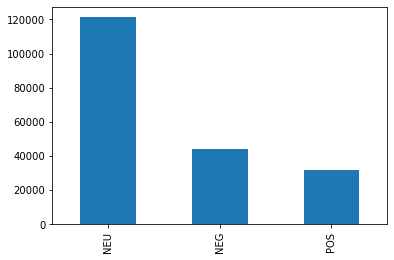

In [11]:
bar_data = frases["sent_winner_value"].value_counts()

grafica = bar_data.plot.bar(x=bar_data[0], y=bar_data[1])

Como resultado podemos notar que en este nuevo modelo se considera que la mayoría de las frases son neutras, a diferencia del anterior que las consideraba negativas.

En lo que se refiere al análisis de emociones, podemos mostrar también una gráfica con los resultados ofrecidos por el modelo.

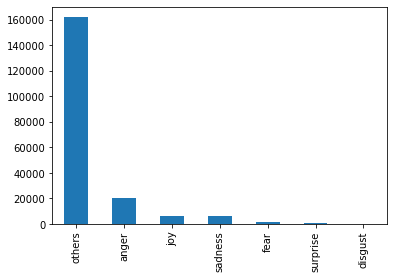

In [10]:
emo_data = frases.emo_winner_value.value_counts()

grafica = emo_data.plot.bar(x=emo_data[0], y=emo_data[1])

Al igual que en el caso anterior, la mayoría de las emociones detectadas entran en la categoría de “otras”, es decir que no encuadran en las categorías predefinidas.

Una ventaja que presenta “pysentimiento” frente a “sentiment_analysis_spanish” es que está basado en “BETO” que a su vez es un modelo BERT entrenado en español. Esto permite que se pueda hacer una afinación (“fine tunning”) con los métodos que ofrece “transformer” para mejorar su entrenamiento a partir de los datos que se tienen. Sin embargo, dicho entrenamiento requiere mayor tiempo para su desarrollo y está fuera del alcance del presente proyecto, pues la meta era aplicar un modelo pre entrenado.